<a href="https://colab.research.google.com/github/alimudasirpcr/plant-disease-detection-using-ml/blob/main/Copy_of_Plant_Diseases_Detection_with_TF2_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite End-to-End Android Application

By [Mudasir Hussain]

For this project,  we will create an end-to-end Android application with TFLite that will then be open-sourced as a template design pattern.

 We opte to develop an **Android application that detects plant diseases**. 



The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite
* Documenting and open-sourcing the development process






##**Machine Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network


### **Importing  the Librairies**

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.4'


     |████████████████████████████████| 454.7MB 37kB/s 
     |████████████████████████████████| 4.2MB 31.8MB/s 
     |████████████████████████████████| 471kB 35.1MB/s 
     |████████████████████████████████| 5.5MB 24.8MB/s 
     |████████████████████████████████| 1.3MB 28.5MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021061200 which is incompatible.
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900
     |████████████████████████████████| 81kB 6.1MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully un

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals



import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.executing_eagerly

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.6.0-dev20210612
Eager mode:  False
Hub version:  0.4.0
GPU is NOT AVAILABLE


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive"

Mounted at /content/drive
 016.jpg
'100 pages mcqs.docx'
 12-community-traditional-sna.pdf
 1.2.pdf
 13-communities-1.pdf
 14-communities-2.pdf
'1527324945740_Lecture 9B.pdf'
'1527328373638_Lecture 10.pdf'
 15-communities-3.pdf
'_$18-19 Mushtaq_Thesis (After Final Defanse).docx'
 1_Message_Design.gdoc
 2019_CPI_FULLDATA.zip
'3rd Feed Back.gdoc'
 academy-21nulled.rar
 achievers.gdoc
 all-punctuation-powerpoint.pdf
"Americans will be the losers of Trump's policy on TPP, NAFTA - Japan Today.html"
'Ami docs'
 Anamta
'An Era of Authoritarian Influence.docx'
'Apevelo credentials.docx'
 asad.gslides
'Assignment ia.gdoc'
 _ATH0016.CR2
'booking schema.gdoc'
'BREXIT_ A VERY BRITISH REVOLUTION (Brexit Essay Sample for CSS).html'
'China’s New Helmsman.docx'
'Cities Mapping.htm'
'Class notes IA.gdoc'
'Client Dashboard.xlsx'
'Colab Notebooks'
'commonaly used medications .gsheet'
 credentials.gdoc
 credentials.txt
 Credentisla.gdoc
 cred.gsheet
'Critical Review .gdoc'
'Downloads - Shortcut.lnk'
 Down

In [ ]:
!unzip -q "/content/drive/MyDrive/PlantVillage.zip"
zip_file = '/content/PlantVillage';

### Prepare training and validation  dataset
Create the training and validation directories 

In [ ]:
data_dir = os.path.join('/content', 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/PlantVillage/train : 3276files
total images for validation : /content/PlantVillage/valid : 1831files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [ ]:
import json

with open('/content/PlantVillage/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Tomato___Bacterial_spot__low', 'Tomato___Bacterial_spot__medium', 'Tomato___Bacterial_spot_high', 'Tomato___Early_blight__low', 'Tomato___Early_blight__medium', 'Tomato___Early_blight__high', 'Tomato___Late_blight__low', 'Tomato___Late_blight__medium', 'Tomato___Late_blight__high', 'Tomato___Leaf_Mold__low', 'Tomato___Leaf_Mold__medium', 'Tomato___Leaf_Mold__high', 'Tomato___Septoria_leaf_spot__low', 'Tomato___Septoria_leaf_spot__medium', 'Tomato___Septoria_leaf_spot__high', 'Tomato___Spider_mites Two-spotted_spider_mite__low', 'Tomato___Spider_mites Two-spotted_spider_mite__medium', 'Tomato___Spider_mites Two-spotted_spider_mite__high', 'Tomato___Target_Spot__low', 'Tomato___Target_Spot__medium', 'Tomato___Target_Spot__high', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus__low', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus__medium', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus__high', 'Tomato___Tomato_mosaic_virus__low', 'Tomato___Tomato_mosaic_virus__medium', 'Tomato___Tomato_mosaic_virus__high', '

In [ ]:
print('Number of classes:',len(classes))

Number of classes: 28


###Select the Hub/TF2 module to use

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 1831 images belonging to 28 classes.
Found 3276 images belonging to 28 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,),output_shape=[FV_SIZE])




In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2049000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                28028     
Total params: 23,879,812
Trainable params: 2,077,028
Non-trainable params: 21,802,784
_________________________________________________________________


### Specify Loss Function and Optimizer

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train Model
train model using validation dataset for validate each steps

In [ ]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/5
51/51 [==============================] - ETA: 0s - batch: 25.0000 - size: 62.9804 - loss: 2.3079 - accuracy: 0.5682 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


51/51 [==============================] - 1238s 24s/step - batch: 25.0000 - size: 62.9804 - loss: 2.3078 - accuracy: 0.5682 - val_loss: 3.2993 - val_accuracy: 0.2467
Epoch 2/5
51/51 [==============================] - 1232s 24s/step - batch: 25.0000 - size: 62.9804 - loss: 1.7345 - accuracy: 0.5993 - val_loss: 2.9093 - val_accuracy: 0.2645
Epoch 3/5
51/51 [==============================] - 1237s 24s/step - batch: 25.0000 - size: 62.9804 - loss: 1.5792 - accuracy: 0.6248 - val_loss: 2.4149 - val_accuracy: 0.3638
Epoch 4/5
51/51 [==============================] - 1243s 25s/step - batch: 25.0000 - size: 62.9804 - loss: 1.4885 - accuracy: 0.6529 - val_loss: 2.5541 - val_accuracy: 0.3147
Epoch 5/5
51/51 [==============================] - 1248s 25s/step - batch: 25.0000 - size: 64.0000 - loss: 1.3565 - accuracy: 0.6820 - val_loss: 2.2166 - val_accuracy: 0.3923


###Check Performance
Plot training and validation accuracy and loss

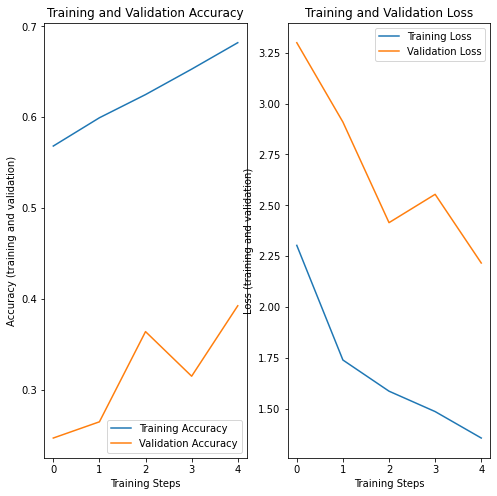

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test
Random sample images from validation dataset and predict

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Tomato_mosaic_virus__medium, file: Tomato___Tomato_mosaic_virus__medium/33f5422e-7889-4ab4-ab53-93507cc83f78___PSU_CG 2261_270deg.JPG


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus__high, confidence: 0.139289


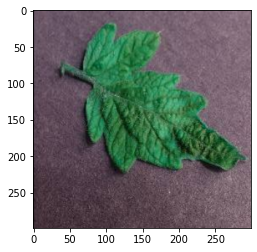

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Early_blight__medium, file: Tomato___Early_blight__medium/250df77c-cb57-4e85-9cf2-531033930030___RS_Erly.B 6477.JPG
PREDICTED: class: Tomato___Early_blight__medium, confidence: 0.086682


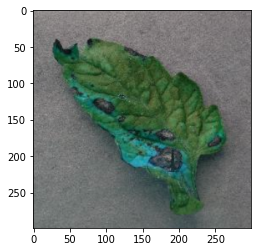

SOURCE: class: Tomato___healthy, file: Tomato___healthy/02b4afdf-e1de-4c0e-a38d-3f19afeb9ea9___RS_HL 0493_flipTB.JPG
PREDICTED: class: Tomato___healthy, confidence: 0.605488


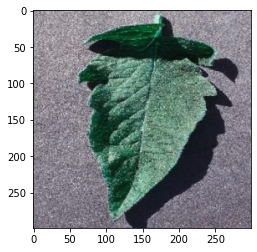

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___healthy, file: Tomato___healthy/e2bd556e-fe0f-4a97-819c-83dbc4a61ac5___GH_HL Leaf 429.JPG
PREDICTED: class: Tomato___healthy, confidence: 0.980869


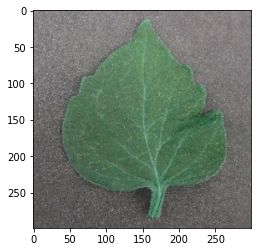

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Early_blight__high, file: Tomato___Early_blight__high/9744fa97-16b3-4a16-afc0-c86ac0397759___RS_Erly.B 6411_flipTB.JPG
PREDICTED: class: Tomato___Septoria_leaf_spot__high, confidence: 0.141855


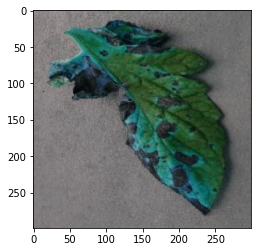

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export as saved model and convert   to TFLite
Now that you've trained the model, export it as a saved model

In [ ]:
import time
t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
# tf.keras.experimental.export_saved_model(model, export_path)
export_path = "./my_model.h5"
model.save(export_path) #save your model 

export_path


'./my_model.h5'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
#  reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___healthy, file: Tomato___healthy/2a1dd125-ece3-499f-a24b-1d00dbcc3184___GH_HL Leaf 227_new30degFlipLR.JPG


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PREDICTED: class: Tomato___healthy, confidence: 0.814898


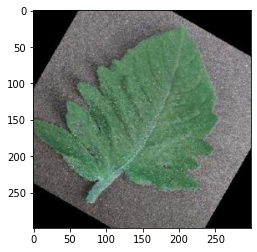

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Target_Spot__medium, file: Tomato___Target_Spot__medium/7bfa2366-1fd0-475b-aadf-d72055b6ec29___Com.G_TgS_FL 0850.JPG
PREDICTED: class: Tomato___healthy, confidence: 0.650076


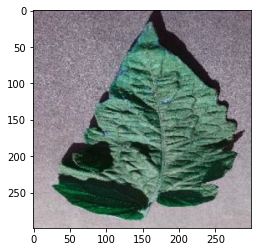

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model('/') # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


NotImplementedError: ignored

## CONCLUSION
The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy! Let's develop an Android app that uses this model.